In [1]:
import odl
import scipy.signal
%matplotlib inline
import astra
import numpy as np
import scipy.sparse.linalg
from algorithmImpls import *
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from ImageSliceViewer3D import *
import matplotlib as mpl
from tqdm import tqdm
mpl.rcParams['figure.figsize'] = (10, 10)
from plot_utils import *
from registration_utils import*
from skimage.filters import try_all_threshold, threshold_mean, threshold_minimum, threshold_otsu, threshold_isodata

### Load projection data

In [2]:
def load_volume(filepath):
    files = [file for file in np.sort(listdir(filepath)) if file.endswith(".npy")]
    height, width = np.load(join(filepath,files[0])).shape
    depth = len(files)
    volume = np.zeros((depth, height, width))
    for i,file in tqdm(enumerate(files)):
        volume[i,:,:] = np.load(join(filepath,file))

    volume = volume[:,:,:].astype('float32')
    return volume

def theta_from_t(t, frames=240, pis = 8):
    alpha = pis*np.pi/frames
    return alpha*t-np.pi/6

volume = load_volume("../PhantomGenerator/output/slow_fast")
volume = volume[:,32:480,32:480].astype('float32')
volume.shape

240it [00:00, 466.09it/s]


(240, 448, 448)

### Define parameters for reconstruction which are equal for all algorithms

In [3]:
num_angles = 30#number of angles pr. frame
num_angles_pi = 30 #number of angles for one full rotation

frames, szrow, szcol = volume.shape#-num_angles#210#this is number of frames we can reconstruct

##We fix some of the rotation here (reconstruction is rotated compared to ground truth)
#translation = np.pi/7
#thetas_all = np.linspace(0-translation,8*np.pi-translation,frames,False) #angles for full acquisition

strt_stp_idx = int(num_angles/2)
frame_idx = np.array((range(0,frames)))
frames_to_reconstruct = np.array([30, 50, 175, 200])

ground_truth = load_volume("../PhantomGenerator/output/slow_fast_no_rotation")[strt_stp_idx:-strt_stp_idx,106:406,106:406]
#ground_truth_rapid = load_volume("../PhantomGenerator/output/fast_no_rotation")[strt_stp_idx:-strt_stp_idx,106:406,106:406]
#ground_truth_slow = load_volume("../PhantomGenerator/output/slow_no_rotation")[fstrt_stp_idx:-strt_stp_idx,106:406,106:406]

240it [00:00, 450.33it/s]


### Angle scheme:

0it [00:00, ?it/s]/home/mette/github/DynamicExplore/plot_utils.py:182: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0,a[x].real],[0,a[x].imag],'ro-',label='python', color = color, alpha=0.2)
4it [00:00, 19.34it/s]


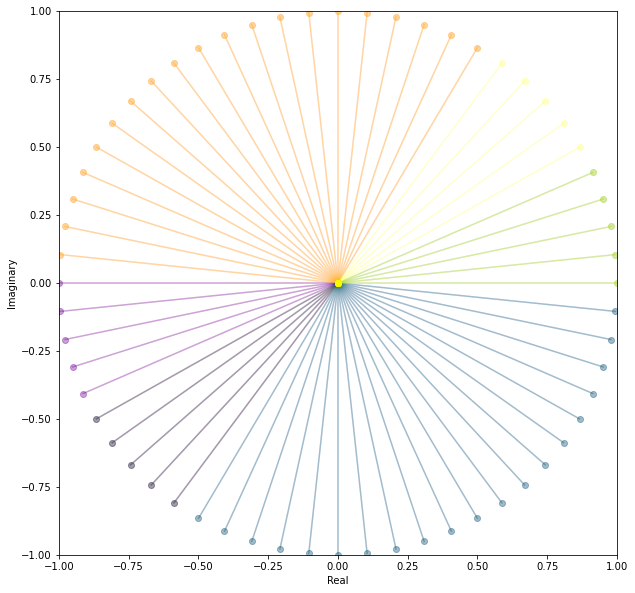

In [4]:
color_list = ['red', 'blue', 'green', 'yellow']
    
#for frame_list in frame_idxs:
for i,frame in tqdm(enumerate(frames_to_reconstruct)):
    f = np.where(frame_idx == frame)[0][0]#frame)
    ts = frame_idx[f-strt_stp_idx:f+strt_stp_idx]
    angles = np.array([theta_from_t(t) for t in ts])
    c = P2R(np.ones(len(angles)), angles)
    argand(c, color_list[i])    


### Reconstruction 2D static frame 50, TV Regularization, different $\lambda$ values

In [5]:
lamdas = [0.01, 0.005, 0.001, 0.0001] #this parameter controls degree of regularization - useless for many angles/little noise, smoother reconstructions for few angles
##VERY IMPORTANT THING HERE IS THAT DETECTOR PARTITION NEEDS TO BE LARGE COMPARED TO ANGLES; OR IT'SFOR SOME REASON NOT PRETTY _ WHY?
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[300, 300], dtype='float32')

result = np.zeros((len(lamdas), reco_space.shape[0], reco_space.shape[1]))

f = 50
ts = frame_idx[f-strt_stp_idx:f+strt_stp_idx]
angles = np.array([theta_from_t(t) for t in ts])
angle_partition = odl.uniform_partition(angles[0], angles[-1], num_angles)
detector_partition = odl.uniform_partition(-30, 30, szrow)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
data = np.sum(volume[:,:,:], axis=1)[ts]

for i, lamda in tqdm(enumerate(lamdas)):
    result[i,:,:] = TVRecon(data, geometry, reco_space, lamda).data
    
recon = np.flip(result, axis=2)

0it [00:00, ?it/s]/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")
4it [00:10,  2.61s/it]


/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


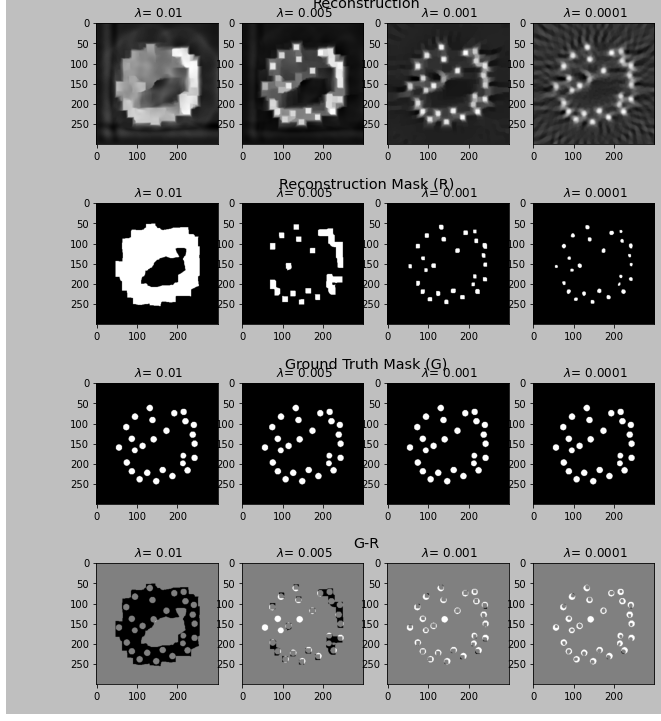

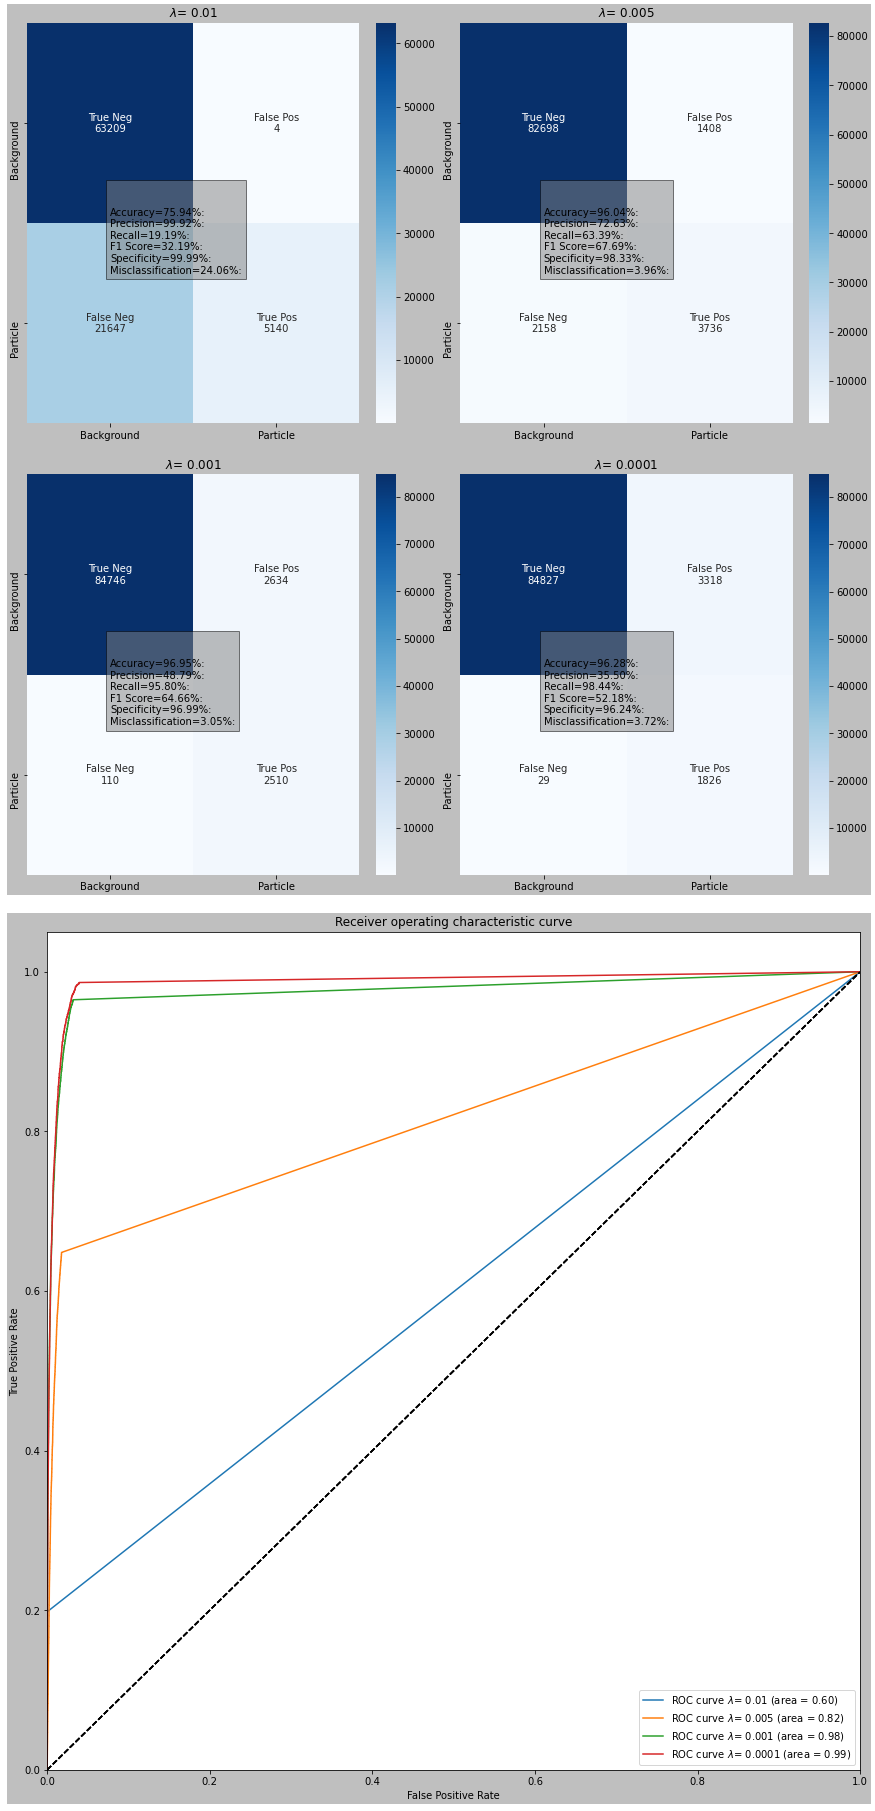

In [6]:
titles = [r'$\lambda$='+f' {l}' for l in lamdas]
GT = np.array([ground_truth[50,:,:]]*len(titles))
plot_results(recon, GT , titles, threshold_minimum, threshold_minimum)
plot_stats(recon, GT, titles, threshold_minimum, threshold_minimum)

### Reconstruction static 2D frame by frame, TV regularixation at $\lambda=0.001$

In [7]:
lamda = 0.001#this parameter controls degree of regularization - useless for many angles/little noise, smoother reconstructions for few angles

result = np.zeros((len(frames_to_reconstruct), reco_space.shape[0], reco_space.shape[1]))

for i,frame in tqdm(enumerate(frames_to_reconstruct)):
    f = np.where(frame_idx == frame)[0][0]#frame)
    ts = frame_idx[f-strt_stp_idx:f+strt_stp_idx]
    angles = np.array([theta_from_t(t) for t in ts])
    angle_partition = odl.uniform_partition(angles[0], angles[-1], num_angles)
    detector_partition = odl.uniform_partition(-30, 30, szrow)
    geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
    data = np.sum(volume[:,:,:], axis=1)[ts]
    result[i,:,:] = TVRecon(data, geometry, reco_space, lamda).data

recon_f = np.flip(result, axis=2)

0it [00:00, ?it/s]/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")
4it [00:10,  2.70s/it]


/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


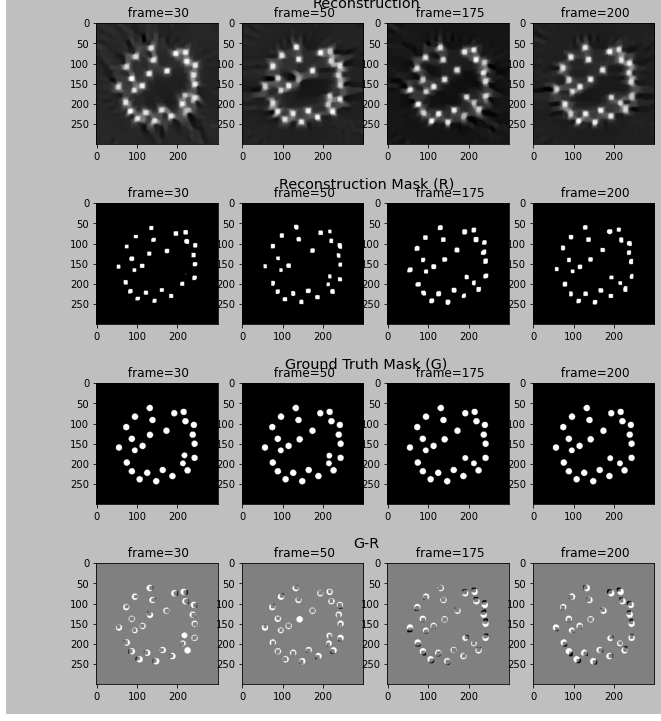

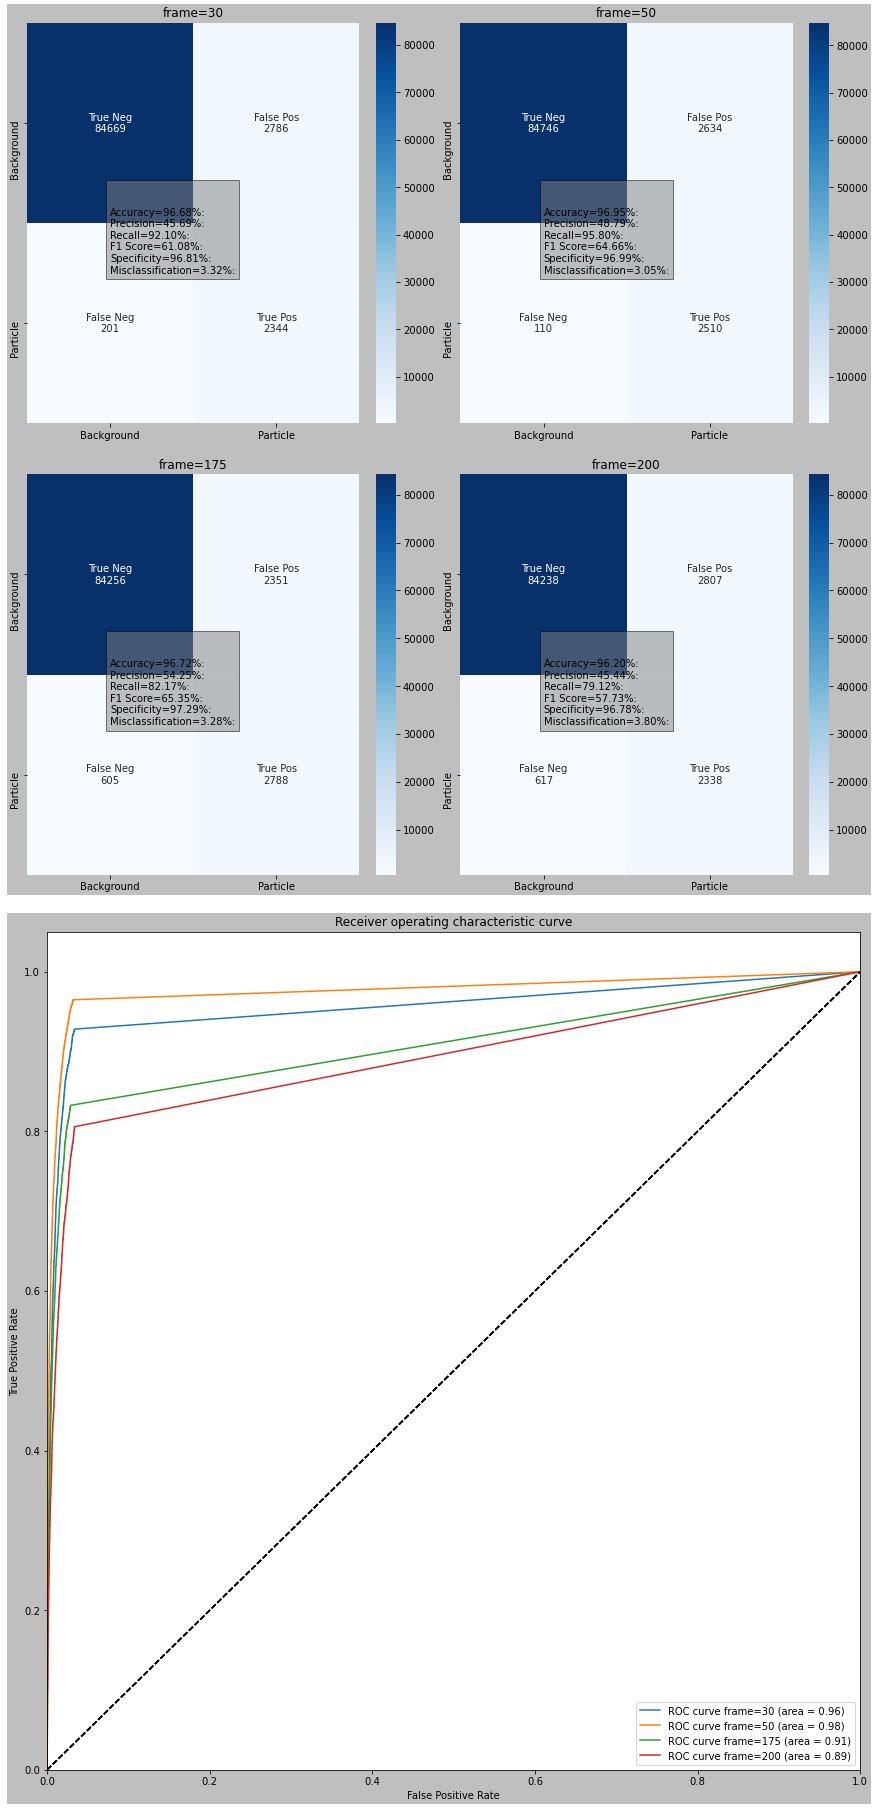

In [8]:
titles = [f'frame={f}' for f in frames_to_reconstruct]
GT = ground_truth[frames_to_reconstruct,:,:]

plot_results(recon_f, GT , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_f, GT, titles, threshold_minimum, threshold_minimum)

### Reconstruction with TV regularization in time dimension, $\lambda_1=0.001$, frame = 50, varying  $\lambda_2$

In [9]:

lamda1 = 0.001
lamda2 = np.array([0.0, 1.0, 5.0, 50.0])

#to save time lets just use frames 0-100. Should be enough. We're only looking at frame 50 and most movement occurs frame 40-60, meaning by using angles 0-100 we get 40 angles with very little movement and we're using 30 for reconstructing each frame
f=50
frame_used_in_recon = 100
sz = 300
ts = range(0,frame_used_in_recon)
thetas_all = np.array([theta_from_t(t) for t in ts]) #angles for full acquisition
detector_partition = odl.uniform_partition(-30, 30, 448)
reconstruction_space = odl.uniform_discr(min_pt=[-20, -20, 0], max_pt=[20, 20, 20], shape=[sz, sz, frame_used_in_recon-num_angles], dtype='float32')

recon_t = np.zeros((len(lamda2), sz,sz))
for i,l in tqdm(enumerate(lamda2)):
    x, sinogram_spaces = TVReconTime(np.sum(volume[0:frame_used_in_recon,:,:], axis=1), reconstruction_space, lamda1, l, frame_used_in_recon-num_angles, thetas_all, num_angles, num_angles_pi, detector_partition)
    recon_t[i,:,:] = np.flip(np.transpose(x.data, (2,0,1)), axis=2)[f-int(num_angles/2)-1]

0it [00:00, ?it/s]/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")
4it [11:50, 177.74s/it]


/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


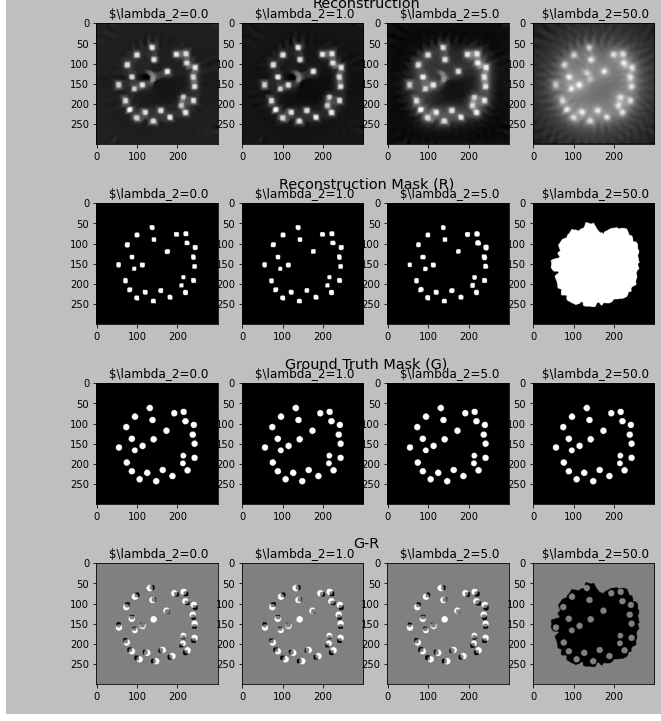

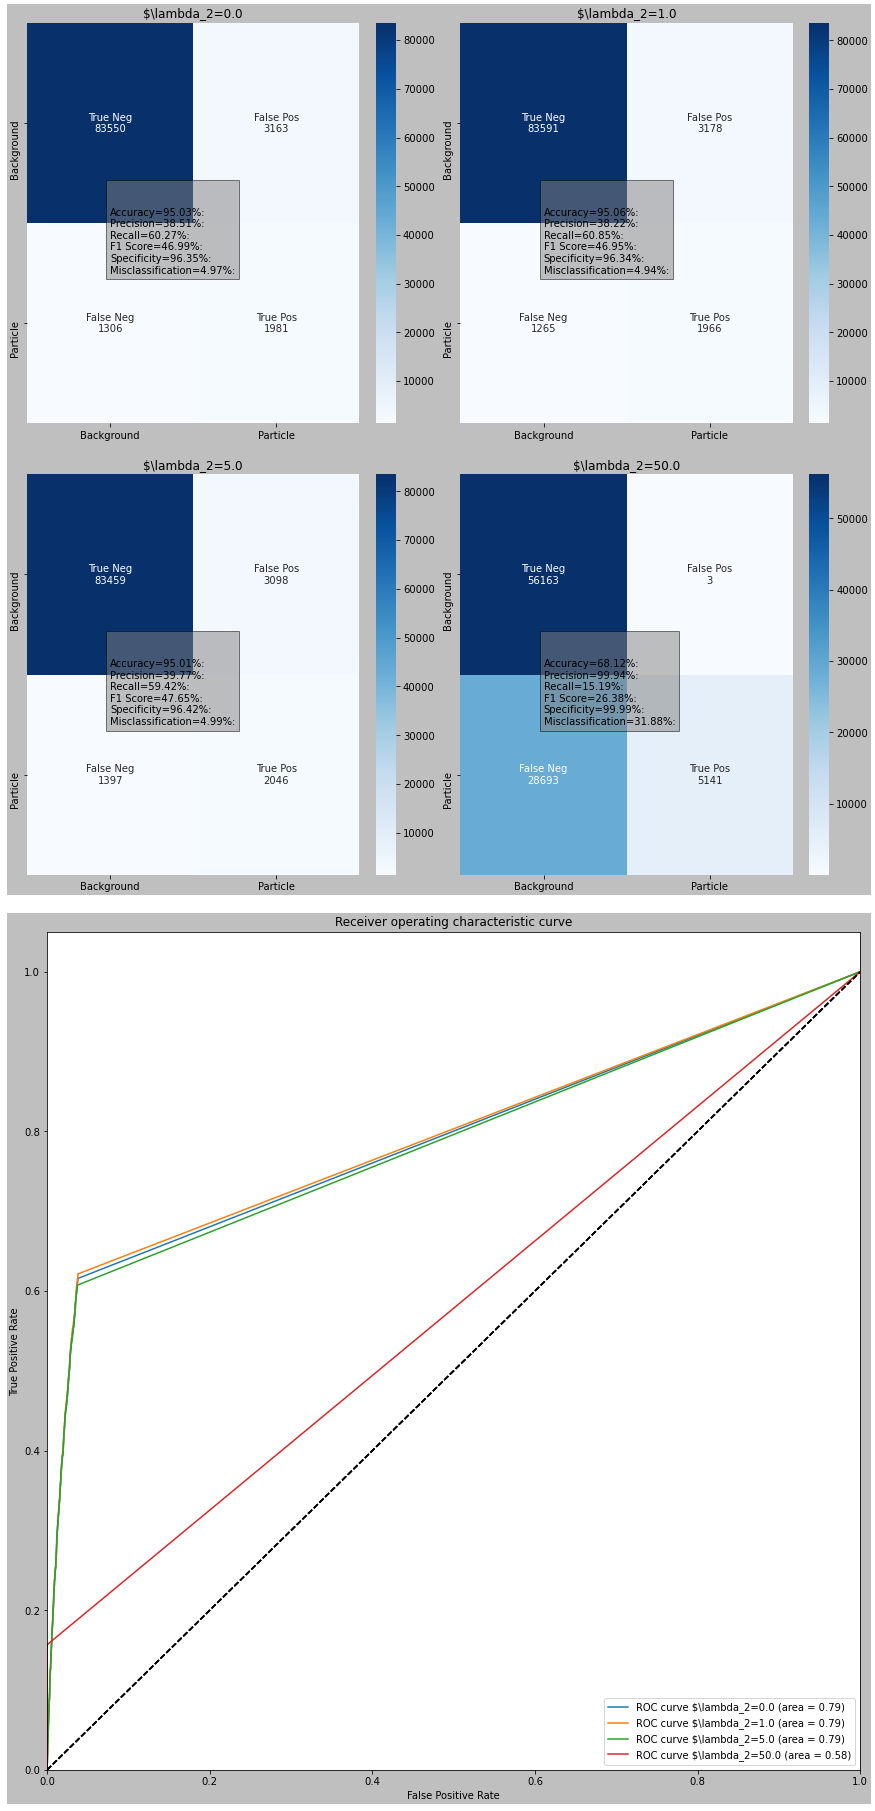

In [10]:
titles = [r'$\lambda_2='+f'{l}' for l in lamda2]
GT = np.array([ground_truth[50,:,:]]*len(titles))

plot_results(recon_t, GT , titles, threshold_minimum, threshold_minimum)
plot_stats(recon_t, GT, titles, threshold_minimum, threshold_minimum)

### Include compression

In [ ]:
lamda2 = 1.0
ps = np.array([0.8, 1.0, 1.3, 1.7])

recon_c = np.zeros((len(ps), sz,sz))
for i,p in tqdm(enumerate(ps)):
    x_comp, sinogram_spaces = TVReconTimeCompression(np.sum(volume[0:frame_used_in_recon,:,:], axis=1), reconstruction_space, lamda1, lamda2, frame_used_in_recon-num_angles, thetas_all, num_angles, num_angles_pi, detector_partition, p=p)
    recon_c[i,:,:] = np.flip(np.transpose(x_comp.data, (2,0,1)), axis=2)[f-int(num_angles/2)-1]

0it [00:00, ?it/s]/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


In [ ]:
titles = [f'p={p}' for p in ps]
GT = np.array([ground_truth[50,:,:]]*len(titles))

plot_results(recon_c, GT , titles, threshold_mean, threshold_otsu)
plot_stats(recon_c, GT, titles, threshold_mean, threshold_otsu)